# Image Processing SS 18 - Assignment - 09

### Deadline is 20.6.2016 at 8:00 o'clock

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.io.wavfile
from skimage.data import astronaut
from skimage.color import rgb2gray
import scipy.fftpack as sci_fft

from __future__ import division
import random
try:
    from StringIO import StringIO as BytesIO
except ImportError:
    from io import BytesIO
    
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
    
    
from numpy.fft import fft2 as numpy_fft2, ifft2 as numpy_ifft2
from scipy.fftpack import dct, idct
from PIL import Image
import itertools
import IPython
import zipfile
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - JPEG - 10 Points

The Wikipedia page about [JPEG-Komprimierung](https://de.wikipedia.org/wiki/JPEG#Die_JPEG-Komprimierung) gives
a good overview. The Wikipedia pages also assumes that all images are between 0 and 255. That is why we do not convert it to 0-1 as an exception.

In [3]:
img = astronaut() # The 
img.shape

(512, 512, 3)

In [4]:
class Blocks:
    """Transforms an image to blocks. A (512, 512) image will become an (64, 64, 8, 8) numpy array"""
    def __init__(self, block_size=8):
        self.block_size = block_size
        
    def __call__(self, img):
        b = self.block_size
        heigth, width = img.shape
        assert img.shape[0] % b == 0
        assert img.shape[1] % b == 0
        blocks = np.zeros((heigth // b, width // b, b, b), dtype=img.dtype)
        for i in range(0, heigth // b):
            for j in range(0, heigth // b):
                blocks[i, j] = img[i*b:(i+1)*b, j*b:(j+1)*b]
        return blocks

    def invert(self, blocks):
        bh, bw = blocks.shape[:2]
        b = self.block_size
        heigth, width = (bh*self.block_size, bw*self.block_size)

        img = np.zeros((heigth, width), dtype=blocks.dtype)
        for i in range(0, bh):
            for j in range(0, bw):
                img[i*b:(i+1)*b, j*b:(j+1)*b] = blocks[i, j]
        return img
    

img_blocks = Blocks(block_size=8)(img[:, :, 0])
print(img_blocks.shape)
assert img_blocks.shape[2:] == (8, 8)
img_inv = Blocks(block_size=8).invert(img_blocks)
assert (img[:, :, 0] == img_inv).all()

(64, 64, 8, 8)


Pic 1
(512, 512)


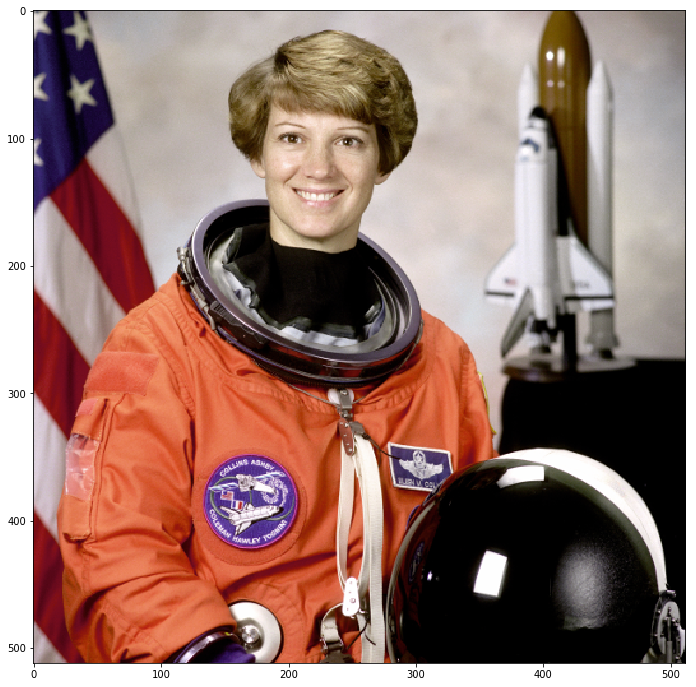

Pic 2


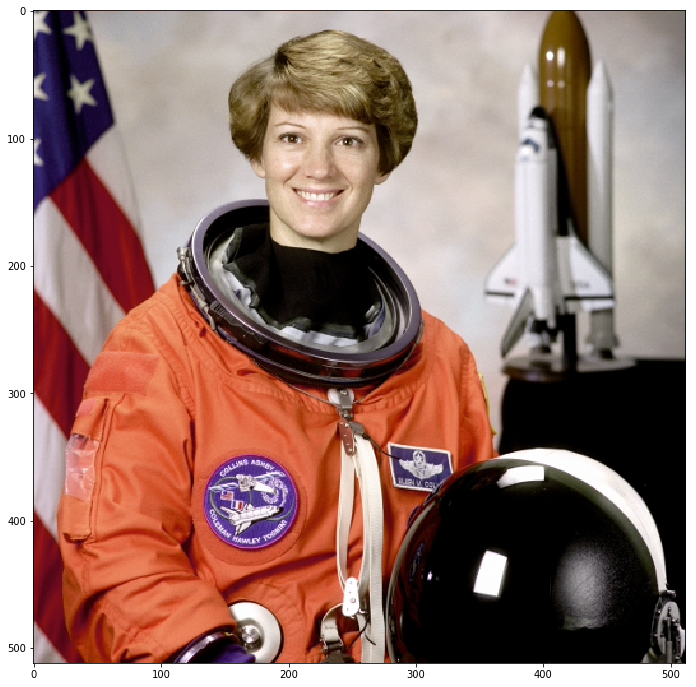

In [5]:
from scipy.misc import imresize
from scipy.ndimage import zoom

def subsample_channel(channel_img, shape):
    sub = np.zeros(shape)
    operand = channel_img.shape[0] // shape[0]
    for i in range(sub.shape[0]):
        for j in range(sub.shape[1]):
            i_img = i * operand
            j_img = j * operand
            sub[i, j] = sum(
                [channel_img[i_img - 1, j_img],
                channel_img[i_img, j_img - 1],
                channel_img[i_img + 1, j_img],
                channel_img[i_img, j_img + 1]]
            ) / 4
    return sub
            
def subsample(ycbcr_img, shape, channel):
#     return ycbcr_img[::2, ::2, channel]
    return subsample_channel(ycbcr_img[:, :, channel], shape)

class ChromaSubsampling:
    """See https://en.wikipedia.org/wiki/YCbCr."""
    ycbcr = np.array([
        [0.299,  0.587,  0.114],
        [-0.168736, -0.331264,  0.5],
        [0.5, -0.418688, -0.0813],
    ])
    
    def __call__(self, rgb_img):
        """Transforms the rgb image to YCbCr. The cb and cr channels have half the resolution of the Y-channel.
           You can simply use the mean of four neighbours.
        """
        shape = rgb_img.shape
        
        ycbcr_img = np.dot(self.ycbcr, rgb_img.reshape(-1, 3).T)
        ycbcr_img = ycbcr_img.T.reshape(shape)
        
        # subsample the cb and cr channel, so that they have half the resolution of the Y-channel.
        # A simple thing might be to use the mean of 4 neighbours.
        # your code here
        half_resolution_shape = tuple(int(x/2) for x in shape[:2])
        cb_sub = subsample(ycbcr_img, half_resolution_shape, 1)
        cr_sub = subsample(ycbcr_img, half_resolution_shape, 2)
        
        return ycbcr_img[:, :, 0], cb_sub, cr_sub
    
    def invert(self, inputs):
        y, cb, cr = inputs
        ycbcr_img = np.stack([
            y,
            zoom(cb, 2),
            zoom(cr, 2)
        ], axis=-1)
        shape = ycbcr_img.shape
        rgb_img = np.dot(np.linalg.inv(self.ycbcr), ycbcr_img.reshape(-1, 3).T)
        rgb_img = rgb_img.T.reshape(shape).clip(0, 255)
        
        return rgb_img.astype(np.uint8)

class DCTofBlocks:
    def __call__(self, blocks):
        """Returns the DCT of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficents."""
        # you can use any function from np.fft or scipy.fftpack
        # your code here
        result = np.zeros_like(blocks)
        for row in range(0,len(blocks)):
            for column in range(0,len(blocks[0])):
                result[row][column] = dct(dct(blocks[row][column].T, norm='ortho').T, norm='ortho')
        return result
    
    def invert(self, blocks):
        """Computes the inverse DCT."""
        # you can use any function from np.fft or scipy.fftpack
        # your code here
        result = np.zeros_like(blocks)
        for row in range(0,len(blocks)):
            for column in range(0,len(blocks[0])):
                blocks[row][column] = idct(idct(blocks[row][column].T, norm='ortho').T, norm='ortho')
        return blocks 

class Quantizise:
    def __init__(self, threshold=1):
        # you can use the Q matrix from wikipedia or invent your own.
        self.q_matrix = [[10,15,25,37,51,66,82,100],
                         [15,19,28,39,52,67,83,101],
                         [25,28,35,45,58,72,88,105],
                         [37,39,45,54,66,79,94,111],
                         [51,52,58,66,76,89,103,119],
                         [66,67,72,79,89,101,114,130],
                         [82,83,88,94,103,114,127,142],
                         [100,101,105,111,119,130,142,156]]
        self.threshold = threshold

    def __call__(self, blocks):
        """Divides the blocks by the `q_matrix` elementwise. Coefficents under the `threshold` will be set to zero."""
        # your code here
        result = blocks / self.q_matrix
        result[result < self.threshold] = 0
        return result
#         result = np.zeros_like(blocks)
#         for row in range(0,len(blocks)):
#             for column in range(0,len(blocks[0])):
#                 for b_row in range(0,len(self.q_matrix)):
#                     for b_column in range(0,len(self.q_matrix[0])):
#                         a = blocks[row][column][b_row][b_column]/self.q_matrix[b_row][b_column]
#                         if a<self.threshold:
#                             result[row][column][b_row][b_column] = 0
#                         else:
#                             result[row][column][b_row][b_column] = a
#                         '''
#                         else:
#                             blocks[row][column][b_row][b_column] = a
#                         '''
#         return result
    
    def invert(self, blocks):
        """ For inverting multiply your elements piecewise with the Q-Matrix"""
        return blocks * self.q_matrix
#         result = np.zeros_like(blocks)
#         for row in range(0,len(blocks)):
#             for column in range(0,len(blocks[0])):
#                 for b_row in range(0,len(self.q_matrix)):
#                     for b_column in range(0,len(self.q_matrix[0])):
#                         result[row][column][b_row][b_column] = blocks[row][column][b_row][b_column]*self.q_matrix[b_row][b_column]
#         return result

class PickNthHighest():
    def __init__(self, n=1):
        self.n = n

    def __call__(self, blocks):
        """Pick the nth-highest frequencies"""
        # your code here
        mask = np.flip(np.tril(np.ones(blocks.shape), self.n - 8), axis=0)
        result = blocks.copy()
        result[np.logical_not(mask.astype(np.bool))] = 0
        return result
#         print("mask", mask)
        
#         z_matrix = np.array([[1, 2, 6, 7,  15, 16, 28, 29], 
#                          [3, 5, 8, 14, 17, 27, 30, 43],
#                          [4, 9, 13,18, 26, 31, 42, 44],
#                          [10,12,19,25, 32, 41, 45, 54], 
#                          [11,20,24,33, 40, 46, 53, 55], 
#                          [21,23,34,39, 47, 52, 56, 61], 
#                          [22,35,38,48, 51, 57, 60, 62], 
#                          [36,37,49,50, 58, 59, 63, 64]])
#         for ix, iy in np.ndindex(z_matrix.shape):
#             if z_matrix[ix][iy]>64-self.n:
#                 z_matrix[ix][iy] = 0
                
#         for row in range(0,len(blocks)):
#             for column in range(0,len(blocks[0])):
#                 for b_row in range(0,len(z_matrix)):
#                     for b_column in range(0,len(z_matrix[0])):
#                         if z_matrix[b_row][b_column] == 0:
#                             blocks[row][column][b_row][b_column] = blocks[row][column][b_row][b_column]*z_matrix[b_row][b_column]
#         return blocks
    
    def invert(self, blocks):
        """There is no way to invert this operation. Just return the inputs."""
        return blocks

#plt.imshow(ChromaSubsampling()(astronaut())[0], cmap='gray')
print("Pic 1")
print(ChromaSubsampling()(img)[0].shape)
plt.imshow(img)
plt.show()
print("Pic 2")
plt.imshow(ChromaSubsampling().invert(ChromaSubsampling()(img)))
plt.show()

In [6]:
class ZigZack:
    def __init__(self, n):
        self.n = n
        """Adapted from here: https://rosettacode.org/wiki/Zig-zag_matrix#Python"""
        def key(pair):
            x, y = pair
            return (x+y, -y if (x+y) % 2 else y)

        n = 8
        indexorder = sorted(((x,y) for x in range(n) for y in range(n)), key=key)
        self.xs = np.zeros((self.n**2,), dtype=np.int)
        self.ys = np.zeros((self.n**2,), dtype=np.int)
        self.back = np.zeros((n, n), dtype=np.int)
        for i, (x, y) in enumerate(indexorder):
            self.xs[i] = x
            self.ys[i] = y
            self.back[x, y] = i
            
    def __call__(self, blocks):
        bh, bw, h, w = blocks.shape
        zigzack_blocks = np.zeros((bh, bw, h*w), dtype=blocks.dtype)
        for i, block_row in enumerate(blocks):
            for j, block in enumerate(block_row):
                zigzack_blocks[i, j] = block[self.xs, self.ys] 
        return zigzack_blocks
    
    def invert(self, zigzack_blocks):
        bh, bw, hw = zigzack_blocks.shape
        h = int(np.sqrt(hw))
        blocks = np.zeros((bh, bw, h, h), dtype=zigzack_blocks.dtype)
        for i, zigzack_row in enumerate(zigzack_blocks):
            for j, zigzack in enumerate(zigzack_row):
                blocks[i, j] = zigzack[self.back] 
        return blocks

zigzag = ZigZack(8)
range_mat = np.arange(64).reshape(1, 1, 8, 8)
zigzack_mat = zigzag(range_mat)
assert (zigzag.invert(zigzack_mat) == range_mat).all()

In [7]:
class Compress:
    def __init__(self, dtype=np.int8):
        self.dtype = dtype
        self.max_value = (np.iinfo(dtype).max  / 1.1)
        
    def __call__(self, arr):
        # print("dtype: {}".format(arr.dtype))
        # print("max: {}, min: {}".format(arr.max(), arr.min()))
        scale = max(abs(arr.max()), abs(arr.min()))
        arr = arr / scale 
        arr = arr * self.max_value
        arr = np.rint(arr)
        arr = arr.astype(self.dtype)
        bytearr = arr.data.tobytes()
        
        return zipfile.bz2.compress(bytearr), arr.shape, arr.dtype, scale
    
    def invert(self, inputs):
        bytearr, shape, dtype, scale = inputs
        decom_bytes = zipfile.bz2.decompress(bytearr)
        arr = np.frombuffer(decom_bytes, dtype=self.dtype)
        arr = arr.astype(dtype)
        arr = arr / self.max_value * scale
        return arr.reshape(shape)

range_mat = np.arange(64, dtype=np.float64).reshape(1, 1, 8, 8)
compress = Compress()
compressed = compress(range_mat)
# print((compress.invert(compressed)))
assert np.allclose(compress.invert(compressed), range_mat, 0.5, 0.5)

In [8]:
class Jpeg:
    def __init__(self, stages):
        self.stages = stages
    
    def __call__(self, img):
        y, cb, cr = ChromaSubsampling()(img)
        outputs = []
        for input in [y, cb, cr]:
            output = input
            for stage in self.stages:
                input = output
                try:
                    output = stage(input)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        return outputs
    
    def invert(self, inputs):
        outputs = []
        for output in inputs:
            for stage in self.stages[::-1]:
                input = output
                try:
                    output = stage.invert(input)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        y, cb, cr = outputs
        return ChromaSubsampling().invert([y, cb, cr])
    


In [9]:
def total_size_jpeg(jpeg_output):
    """Summs the number of bytes over the different compression channels: y, cb, cr"""
    nb_bytes = sum([len(x[0]) for x in jpeg_output])
    return "{:.1f}KB".format(nb_bytes / 1000)

def total_size_numpy(arr):
    return "{:.1f}KB".format(len(arr.data.tobytes()) / 1000)

def naive_compression_size(arr):
    bytearr = arr.data.tobytes()
    nb_bytes = len(zipfile.bz2.compress(bytearr))
    return "{:.1f}KB".format(nb_bytes / 1000)

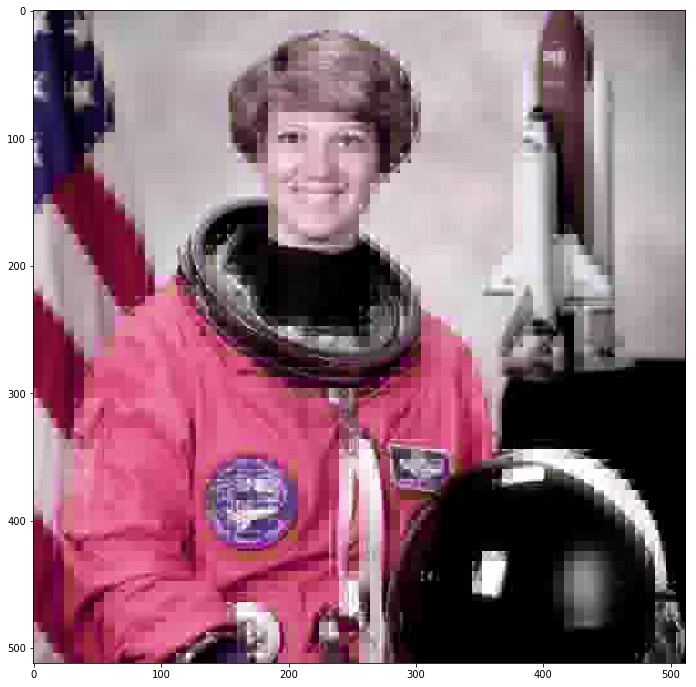

In [19]:
##### build the jpeg pipeline
# for testing you can use only the first ones.
# maybe you have to adjust the Quantizise.threshold settings.
jpeg = Jpeg([Blocks(8), DCTofBlocks(), Quantizise(threshold=2), ZigZack(8), Compress(np.int8)])

img_jpeg = jpeg(img)
img_reconstruct = jpeg.invert(img_jpeg)
assert img_reconstruct.shape == img.shape
# once you implemted ChormaSubsampling.invert this should have colors :)
plt.imshow(img_reconstruct / 255)
plt.show()

In [11]:
chromasubsampling_compression = Jpeg([Blocks(8), Compress()])
print("No compression: " + total_size_numpy(img))
print("Direct compression of the image: " + naive_compression_size(img))
print("Cromasubsampling and compression: " + total_size_jpeg(chromasubsampling_compression(img)))

No compression: 786.4KB
Direct compression of the image: 499.3KB
Cromasubsampling and compression: 203.2KB


In [12]:
# Compare the size of the images if the zigzack encoding is removed.
# Does the size change if the Quantizise.threshold increases?
jpeg_w_o_zigzag = Jpeg([Blocks(8), DCTofBlocks(), Quantizise(threshold=5), Compress(np.uint8)])
# your code here
print("No compression: " + total_size_numpy(img))
print("Direct compression of the image: " + naive_compression_size(img))
print("JPEG without zigzag: " + total_size_jpeg(jpeg_w_o_zigzag(astronaut())))

No compression: 786.4KB
Direct compression of the image: 499.3KB
JPEG without zigzag: 7.3KB


In [13]:
print("JPEG with zigzag: " + total_size_jpeg(jpeg(astronaut())))

JPEG with zigzag: 6.3KB


# Compare the size of the images if the zigzack encoding is removed.
Results as time of writing (using 5 as threshold for quantizise):
JPEG without zigzag: 7.3KB
JPEG with zigzag: 6.3KB
# Does the size change if the Quantizise.threshold increases?
Yes, the size changes when the threshold increases. The higher the threshold, the lower the quality of the resulting picture. 

In [14]:
# Compare the image quality of the `Quantizise` vs. the `PickNthHighest` compressions. Make sure that the outputs 
# are roughly the same size. Why is one better then the other one?
# your code here

q_jpeg = Jpeg([Blocks(8), DCTofBlocks(), Quantizise(threshold=100), Compress()])
# q_img = q_jpeg(astronaut())
# q_img_reconstruct = q_jpeg.invert(q_img)
# plt.imshow(q_img_reconstruct / 255)
# plt.show()

print("No compression: " + total_size_numpy(astronaut()))
print("Cromasubsampling and compression: " + total_size_jpeg(q_jpeg(astronaut())))

No compression: 786.4KB
Cromasubsampling and compression: 24.2KB


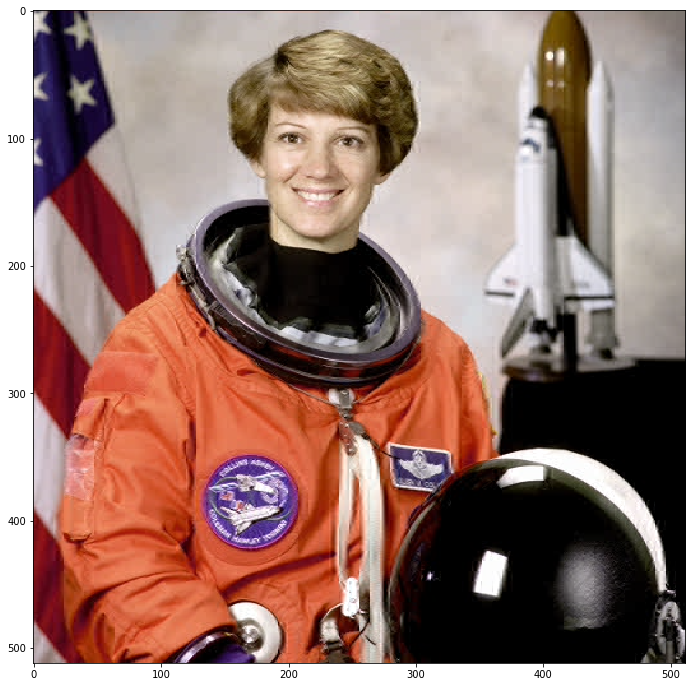

No compression: 786.4KB
Cromasubsampling and compression: 50.2KB


In [21]:
jpeg_w_nthhighest = Jpeg([Blocks(8), DCTofBlocks(), PickNthHighest(10), Compress()])
n_img_reconstruct = jpeg_w_nthhighest.invert(jpeg_w_nthhighest(astronaut()))
plt.imshow(n_img_reconstruct / 255)
plt.show()

print("No compression: " + total_size_numpy(astronaut()))
print("Cromasubsampling and compression: " + total_size_jpeg(jpeg_w_nthhighest(astronaut())))

# Why is one better then the other one?
PickNthHighest basically does the same as a lowpassfilter for each block. It filters the n highest frequencies out. While most of the picture information is still available, it results in blurrier squares while Quantizise does use information of the non-compressed picture to quantizise and filter out more unimportant parts of the picture. PickNthHighest does not use information of the images' dct matrices at all.